In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
from core.database import DwDDataHandler, SensorDataHandler, GoogleDataHandler, UlmDeHandler, WetterComHandler
from core.plotting import draw_plots
from core.core_configuration import load_config, database_config

load_config()
auth = database_config()

In [ ]:
ulmde_handler = UlmDeHandler(auth['db_port'], auth['db_host'], auth['db_user'], auth['db_pw'], 'ulmde_data')
ulmde_handler.init_db_connection()
ulmde_df = ulmde_handler.read_data_into_dataframe()
ulmde_df['timestamp'] = ulmde_df['timestamp'].map(lambda x: datetime.strptime(str(x).strip().replace('+00:00', ''), '%Y-%m-%d %H:%M:%S'))
ulmde_df

In [ ]:
dwd_handler = DwDDataHandler(auth['db_port'], auth['db_host'], auth['db_user'], auth['db_pw'], 'dwd_data')
dwd_handler.init_db_connection()
dwd_df = dwd_handler.read_data_into_dataframe()
dwd_df['timestamp'] = dwd_df['timestamp'].map(lambda x: datetime.strptime(str(x).strip().replace('+00:00', ''), '%Y-%m-%d %H:%M:%S'))
dwd_df = dwd_df.sort_values(by="timestamp")

dwd_df.drop(['id', 'timestamp'],axis=1).describe()

In [ ]:
wettercom_handler = WetterComHandler(auth['db_port'], auth['db_host'], auth['db_user'], auth['db_pw'],'wettercom_data')
wettercom_handler.init_db_connection()
wettercom_df = wettercom_handler.read_data_into_dataframe()
wettercom_df['timestamp'] = wettercom_df['timestamp'].map(lambda x: datetime.strptime(str(x).strip().replace('+00:00', ''), '%Y-%m-%d %H:%M:%S'))
wettercom_df

In [ ]:

google_handler = GoogleDataHandler(auth['db_port'], auth['db_host'], auth['db_user'], auth['db_pw'], 'google_data')
google_handler.init_db_connection()
google_df = google_handler.read_data_into_dataframe()
google_df['timestamp'] = google_df['timestamp'].map(lambda x: datetime.strptime(re.sub('\..*', '', str(x).strip()), '%Y-%m-%d %H:%M:%S'))
google_df = google_df.sort_values(by="timestamp")

google_df

In [ ]:
google_df.drop(['id', 'timestamp'],axis=1).describe()


In [ ]:
handler = SensorDataHandler(auth['db_port'], auth['db_host'], auth['db_user'], auth['db_pw'], 'sensor_data')
handler.init_db_connection(check_table=False)
df = handler.read_data_into_dataframe()
df['timestamp'] = df['timestamp'].map(lambda x : datetime.strptime(str(x).replace("+00:00", "").strip(), '%Y-%m-%d %H:%M:%S'))
df = df.sort_values(by='timestamp')
df = df.reset_index()
#print(str(df['timestamp'][0].month), str(df['timestamp'][0].day))

df

In [8]:
# measurement data collection started on 12th august 2023, 11 hours 32 minutes 54 seconds
assert df['timestamp'][0].day == 12 and df['timestamp'][0].month == 8 and df['timestamp'][0].year == 2023 and df['timestamp'][0].hour == 11 and df['timestamp'][0].minute == 32 and df['timestamp'][0].second == 54

In [ ]:
df[["humidity", "room_temp", "cpu_temp"]].describe()

In [ ]:
corr_matrix = df[["humidity", "room_temp", "cpu_temp"]].corr()
#corr_matrix = df[["humidity", "room_temp"]].corr()
corr_matrix

Creating 2x1 lineplots
{'label': 'Home', 'x': 'timestamp', 'y': 'room_temp'}
inner: {'label': 'DWD Forecast', 'x': 'timestamp', 'y': 'temp', 'alpha': 0.6}
inner: {'label': 'Google Forecast', 'x': 'timestamp', 'y': 'temp', 'alpha': 0.6}
inner: {'label': 'Wetter.com Forecast', 'x': 'timestamp', 'y': 'temp_stat', 'alpha': 0.6}
inner: {'label': 'Wetter.com Live', 'x': 'timestamp', 'y': 'temp_dyn', 'alpha': 0.6}
inner: {'label': 'Ulm Forecast', 'x': 'timestamp', 'y': 'temp', 'alpha': 0.6}
{'label': 'Home', 'x': 'timestamp', 'y': 'humidity', 'color': 'purple'}
inner: {'label': 'Google Forecast', 'x': 'timestamp', 'y': 'humidity', 'alpha': 0.6}


IndexError: index 2 is out of bounds for axis 0 with size 2

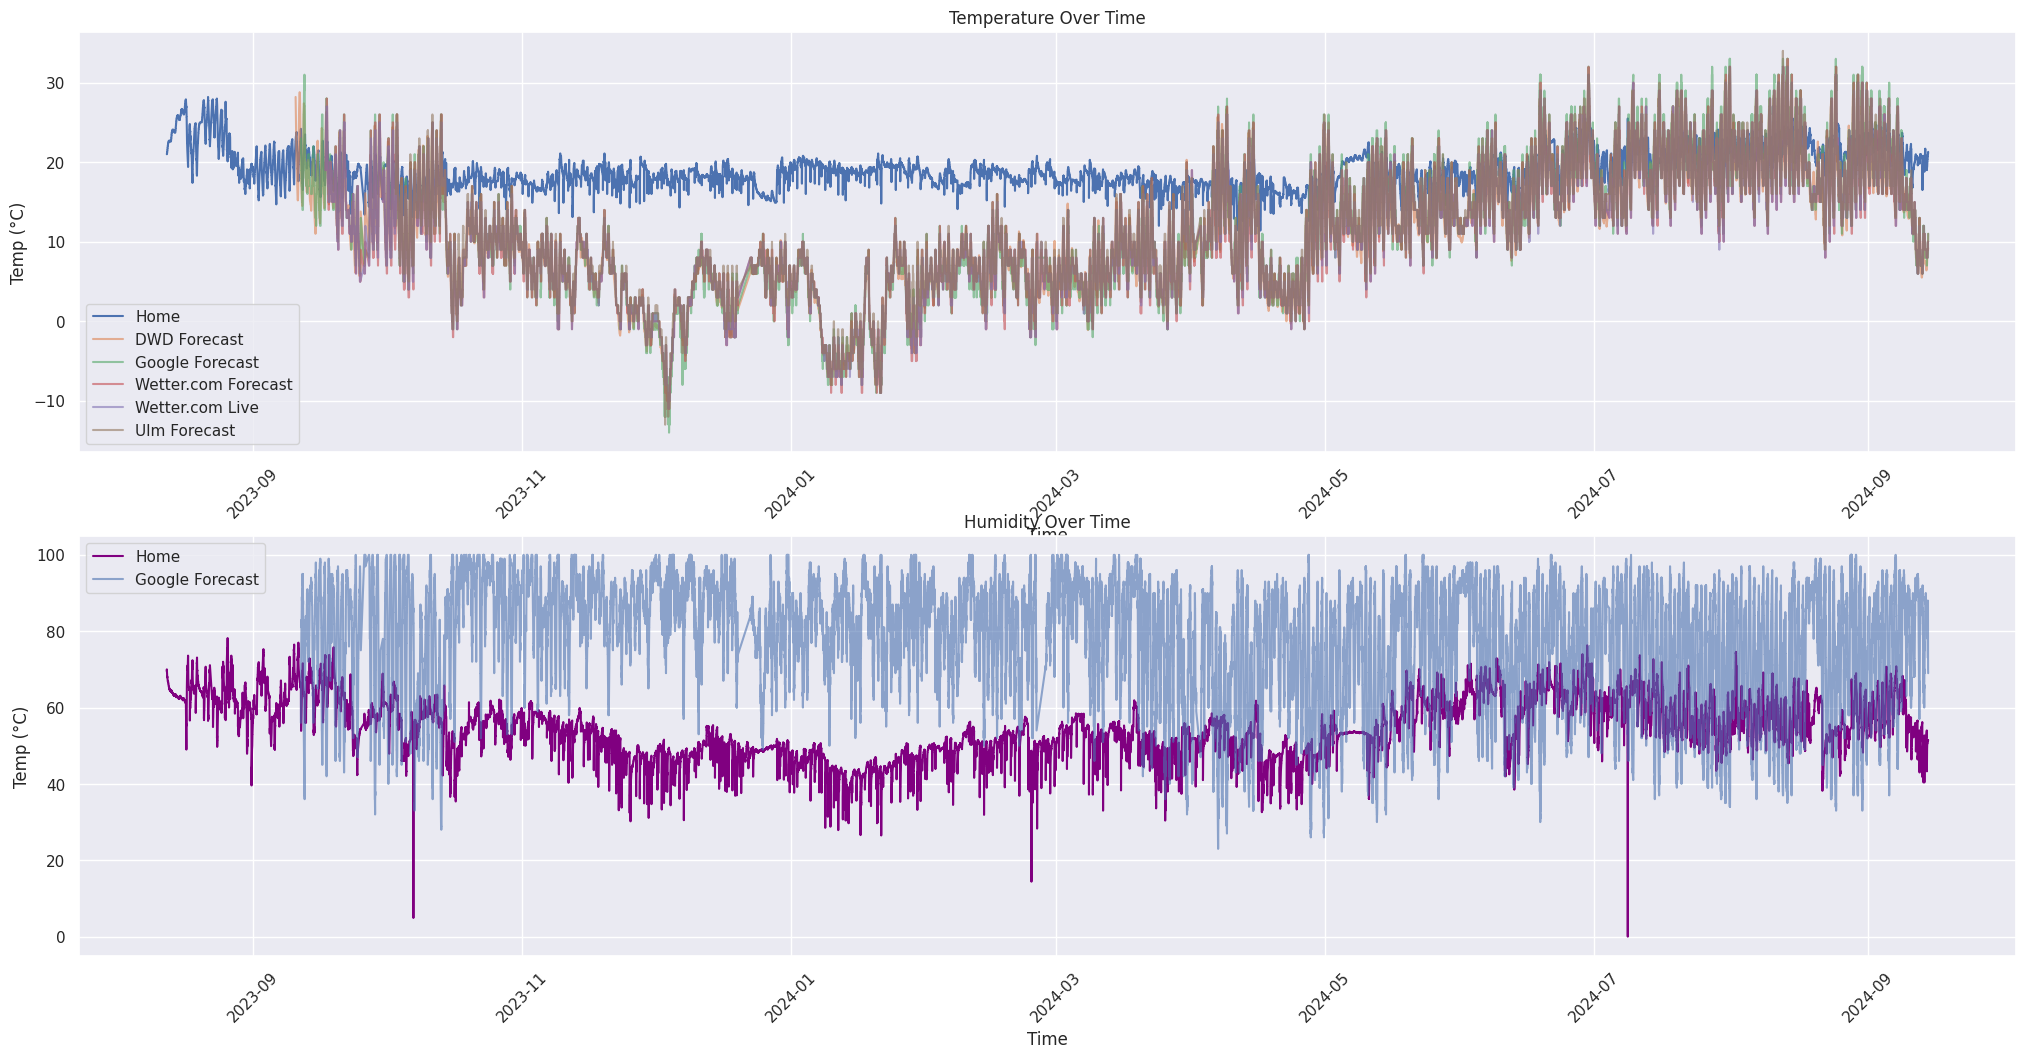

In [16]:
#draw_plots(df,dwd_df=dwd_df,google_df=google_df,wettercom_df=wettercom_df,ulmde_df=ulmde_df, with_save=False)
from core.p import main_plot_params, inner_plots_params, create_multiple_lineplots, _validate_and_sort_timestamp
import pandas as pd
custom_theme = {
    #'context': 'notebook',   # Can be 'paper', 'notebook', 'talk', 'poster'
    'style': 'darkgrid',    # Can be 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'
    'palette': 'deep'        # Can be 'deep', 'muted', 'bright', 'pastel', etc.
}

# Create single plots with the custom theme
#df = _validate_and_sort_timestamp(df)

def last_24h_df(_df):
    last_24h = datetime.now() - timedelta(hours=24)
    return _df[_df['timestamp'] >= last_24h]

#plot1 = create_single_lineplot(df, "Home", "timestamp", "room_temp", theme=custom_theme)
# Combine multiple plots into one figure with the custom theme
df_temp_inner_plt_params = [
            inner_plots_params(dwd_df, "DWD Forecast", "timestamp", "temp"),
            inner_plots_params(google_df, "Google Forecast", "timestamp", "temp"),
            inner_plots_params(wettercom_df, "Wetter.com Forecast", "timestamp", "temp_stat"),
            inner_plots_params(wettercom_df, "Wetter.com Live", "timestamp", "temp_dyn"),
            inner_plots_params(ulmde_df, "Ulm Forecast", "timestamp", "temp")
            ]
df_temp_plt_params = {"main": main_plot_params(df, "Temperature Over Time"), "inner": df_temp_inner_plt_params}
df_temp_24_plt_params = {'main': main_plot_params(last_24h_df(df),"Temperature Last 24 Hours")}

df_hum_plt_params = {"main": main_plot_params(df, "Humidity Over Time", y="humidity",  color="purple"), "inner": [inner_plots_params(google_df, "Google Forecast", "timestamp", "humidity")]}
df_hum_24_plt_params = {'main': main_plot_params(last_24h_df(df),"Humidity Last 24 Hours", y="humidity")}
plots_w_params = [df_temp_plt_params, df_hum_plt_params, df_temp_24_plt_params, df_hum_24_plt_params]
combined_fig, _ = create_multiple_lineplots(plots_w_params, theme=custom_theme, rows=2, cols=2)
combined_fig

#datas = [df, filtered_data]


In [ ]:
plt.figure(figsize=(25, 10))
plt.subplot(2, 1, 1)

sns.lineplot(label="CPU", x="timestamp", y="cpu_temp", data=df)
plt.title("Temperature Over Time")
plt.xlabel("Time")
plt.ylabel("Temp (°C)")
plt.legend()
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
sns.lineplot(label="CPU", x="timestamp", y="cpu_temp",marker='o',markersize=6, data=df[df["timestamp"] >= datetime.now() - timedelta(hours=25)])
plt.title("Temperature Last 24h")
plt.xlabel("Time")
plt.ylabel("Temp (°C)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(25, 10))
plt.subplot(2, 1, 1)
sns.lineplot(label="Google Forecast", x="timestamp", y="wind", data=google_df)
plt.title("Wind Speed Over Time")
plt.xlabel("Time")
plt.ylabel("Speed (Km/h)")
plt.legend()
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
sns.lineplot(label="Google Forecast", x="timestamp", y="precipitation", data=google_df)
plt.title("Precipitation Chance Over Time")
plt.xlabel("Time")
plt.ylabel("precipitation (%)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
fitness = pd.read_csv('fitness.csv')
fitness['time'] = fitness['time'].map(lambda x: datetime.strptime(x, "%d-%m-%Y"))
fitness['weight'] = fitness['weight'].map(lambda x: float(x))
fitness['bmi'] = fitness['bmi'].map(lambda x: float(x))
fitness['body_fat'] = fitness['body_fat'].map(lambda x: float(x))
fitness['muscle'] = fitness['muscle'].map(lambda x: float(x))
fitness['kcal'] = fitness['kcal'].map(lambda x: float(x))
fitness['visceral'] = fitness['visceral'].map(lambda x: float(x))
fitness = fitness.sort_values(by="time")

fitness.drop(['time'], axis=1).describe()

In [ ]:
def plot_fitness(fitness):
    plt.figure(figsize=(25, 10))

    # Visualization 1: Line plot for weight over time
    plt.subplot(2, 2, 1)
    sns.lineplot(data=fitness, x='time', y='weight')
    plt.xticks(rotation=45)
    plt.title('Weight over Time')

    # Visualization 2: Line plot for BMI over time
    plt.subplot(2, 2, 2)
    sns.lineplot(data=fitness, x='time', y='bmi')
    plt.xticks(rotation=45)
    plt.title('BMI over Time')

    # Visualization 3: Line plot for body fat over time
    plt.subplot(2, 2, 3)
    sns.lineplot(data=fitness, x='time', y='body_fat')
    plt.xticks(rotation=45)
    plt.title('Body Fat over Time')

    # Visualization 4: Line plot for muscle over time
    plt.subplot(2, 2, 4)
    sns.lineplot(data=fitness, x='time', y='muscle')
    plt.xticks(rotation=45)
    plt.title('Muscle over Time')

    plt.tight_layout()
    plt.show()

def plot_fitness_corr(fitness):
    correlation_matrix = fitness[["weight", "bmi", "body_fat", "muscle", "kcal", "visceral"]].corr()
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, annot=True,mask=mask, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    plt.show()

plot_fitness(fitness)
plot_fitness_corr(fitness)

def plot_overall_heatmap():
    heat_df = pd.concat([
        df[df["timestamp"] >= datetime.now() - timedelta(hours=25)][["humidity", "room_temp", "cpu_temp"]].rename(lambda x: f"home_{x}", axis="columns"),
        google_df[google_df["timestamp"] >= datetime.now() - timedelta(hours=25)].drop(['id', 'timestamp'],axis=1).rename(lambda x: f"google_{x}", axis="columns"),
        dwd_df[dwd_df["timestamp"] >= datetime.now() - timedelta(hours=25)].drop(['id', 'timestamp'],axis=1).rename(lambda x: f"dwd_{x}", axis="columns")
    ])

    m = heat_df.corr()
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(m, dtype=bool))
    sns.heatmap(m, annot=True,mask=mask, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    plt.show()
    return m

#plot_overall_heatmap()